# Final Project: Toxic Chat Classification Using NLP

## Introduction
In this project, we will be using Natural Language Processing (NLP) to classify toxic comments in a chat. The dataset we will be using is the 
1. ) [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) dataset from Kaggle. The dataset consists of comments from Wikipedia’s talk page edits. The comments are labeled as toxic, severe toxic, obscene, threat, insult, and identity hate. The goal of this project is to build a model that can classify the comments into these categories.
2. ) [Sensai] is a toxic chat dataset consists of live chats from Virtual YouTubers' live streams
   curl -L -o ~/Downloads/archive.zip\ https://www.kaggle.com/api/v1/datasets/download/uetchy/sensai
3. ) [The Toxicity Dataset] This repo contains 500 toxic and 500 non-toxic comments from a variety of popular social media platforms. https://github.com/surge-ai/toxicity

## Members - Cluster D Table 25
1. ) HTUN HTET MYAT
2. )
3. )
4. )
5. )

In [2]:
# Import Statements 
import os
import re
import requests
import nltk
import string
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, Dataset
# import sentencepiece
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
# from symspellpy import SymSpell, Verbosity
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

from keras import models,layers

/Users/blake/NTU/EE6405_NLP/codeenv/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /Users/blake/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/blake/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/blake/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import tensorflow as tf
# List physical devices
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)
else:
    print("No GPU detected.")


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU detected.


In [3]:
# Default Functions to clean the NLP Dataset, remove stopwords, lemmatize, and stem the words
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
    
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


def clean_string(text, stem="None"):

    # Final String to return
    final_string = ""

    # Make the text to be lower case
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]

    # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [4]:
# Start with Cleaning the Data of Kaggle Toxic Comment Dataset

df_kaggle = pd.read_csv('./data/kaggle-toxic-comment-challange/kaggle_train.csv')
df_sensai = pd.concat([pd.read_parquet(x) for x in glob.glob('./data/sensai/*.parquet')], ignore_index=True)
df_surge = pd.read_csv('./data/surge-ai-toxicity-repo/toxicity_en.csv')

## Pretty print alll the dataframes columns
print(df_kaggle.columns)
print(df_sensai.columns)
print(df_surge.columns)


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
Index(['body', 'label'], dtype='object')
Index(['text', 'is_toxic'], dtype='object')


In [5]:
#Combine the toxics labels to simply toxic to combine with other datasets
df_kaggle['toxic'] = df_kaggle[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)
#Drop the other columns
df_kaggle = df_kaggle.drop(columns=['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [6]:
def remove_duplicates(df, text_column):
    df_cleaned = df.drop_duplicates(subset=[text_column], keep='first').reset_index(drop=True)
    return df_cleaned


df_kaggle_cleaned = remove_duplicates(df_kaggle, 'comment_text')
df_sensai_cleaned = remove_duplicates(df_sensai, 'body')
df_surge_cleaned = remove_duplicates(df_surge, 'text')


In [7]:
df_kaggle_cleaned = df_kaggle_cleaned.rename(columns={'comment_text':'comments','toxic':'label'})
df_sensai_cleaned = df_sensai_cleaned.rename(columns={'body':'comments','label':'label'})
df_surge_cleaned = df_surge_cleaned.rename(columns={'text':'comments','is_toxic':'label'})
print(df_kaggle_cleaned.columns)
print(df_sensai_cleaned.columns)
print(df_surge_cleaned.columns)

Index(['id', 'comments', 'label'], dtype='object')
Index(['comments', 'label'], dtype='object')
Index(['comments', 'label'], dtype='object')


In [8]:
# merge
df_combined = pd.concat([df_kaggle_cleaned[['comments','label']], 
                         df_sensai_cleaned[['comments','label']], 
                         df_surge_cleaned[['comments','label']]], 
                         ignore_index=True)
df_combined = df_combined.dropna()
df_combined = remove_duplicates(df_combined, 'comments')
df_combined['text_cleaned'] = df_combined['comments'].apply(lambda x: clean_string(x, stem="Lem"))

df_combined.to_csv('./data/combined_toxicity_data_cleaned.csv', index=False)

In [20]:
#Skipp all to read the cleaned data
df_combined = pd.read_csv('./data/combined_toxicity_data_cleaned.csv')

In [21]:
# Get possible lables values for the dataset
print(df_combined['label'].unique())

['0' '1' 'hidden' 'deleted' 'nonflagged' 'Toxic' 'Not Toxic']


In [22]:
print(df_combined[df_combined['label'] == 0].head(10))
print(df_combined[df_combined['label'] == 1].head(10))
print(df_combined[df_combined['label'] == "deleted"].head(10))
print(df_combined[df_combined['label'] == "nonflagged"].head(10))
print(df_combined[df_combined['label'] == "Toxic"].head(10))
print(df_combined[df_combined['label'] == "Not Toxic"].head(10))
print(df_combined[df_combined['label'] == "hidden"].head(10))

Empty DataFrame
Columns: [comments, label, text_cleaned]
Index: []
Empty DataFrame
Columns: [comments, label, text_cleaned]
Index: []
                                                 comments    label  \
159573                                           ero poto  deleted   
159575               Hagan spam de pien cuando se rinda 😆  deleted   
159577                                        ero poto???  deleted   
159592                                               gey?  deleted   
159593  HINA MI NOVIA ME DIJO YAMETE KUDASAI QUE SIGNI...  deleted   
159629                                                 :v  deleted   
159642                    hina conoces mis memes de juan?  deleted   
159643                                             🏳️‍🌈🇯🇵  deleted   
159645  JESTEM NAPALONY JAK SAM SKURWYSYN🥵🥵🥵🥵🥵🥵🥵🥵🥵🥵🥶🥶🥶...  deleted   
159676   sabías de la Idol de akb48 también habla Español  deleted   

                                             text_cleaned  
159573                             

From here we can see the 0 is not toxic, 1 is toxic, flagged as toxic is toxic, not toxic is not toxic, and can remove the noise deleted and not flagged

In [23]:
df_combined = df_combined[~df_combined['label'].isin(['deleted', 'nonflagged','hidden'])]
df_combined['label'] = df_combined['label'].replace({'Toxic': 1, 'Not Toxic': 0})
# Change rememanats of text and integer datatype to the same String type.
df_combined['label'] = df_combined['label'].replace({'1': 1, '0': 0})
df_combined.dropna(subset=['text_cleaned'],inplace=True)
df_combined.reset_index(drop=True, inplace=True)
print(df_combined['label'].unique())

[0 1]


/var/folders/y0/n_4qtv412193d16p33qfv5t40000gn/T/ipykernel_19290/2814163378.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined['label'] = df_combined['label'].replace({'1': 1, '0': 0})


In [24]:
print(df_combined['label'].unique())

[0 1]


In [25]:
# Find the count of toxic and non-toxic comments
print(df_combined['label'].value_counts())

label
0    143778
1     16725
Name: count, dtype: int64


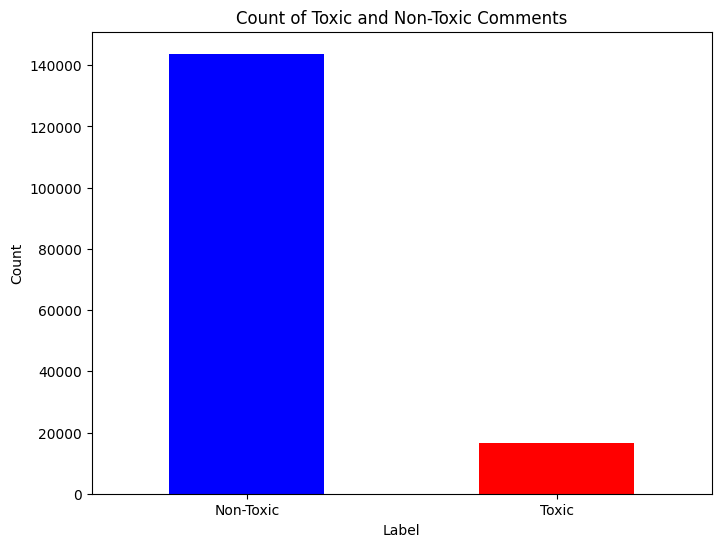

In [26]:
# Count the number of toxic and non-toxic comments
label_counts = df_combined['label'].value_counts()

# Plot the counts
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Count of Toxic and Non-Toxic Comments')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Toxic', 'Toxic'], rotation=0)
plt.show()

In [27]:
# now we see the distribution of the comments is very skewed . Need to balance the dataset
# Split the data into train and test sets

In [28]:
# Split the data into train and test sets with stratification to ensure balance

training_set , test_set = train_test_split(df_combined, test_size=0.2, stratify=df_combined['label'], random_state=42)

In [29]:
# To Create Vectors for Textual Data use the log term frequencey to reduce the weight of common words
# ngram to be 3
VOCAB_SIZE = 5000
encoder = tf.keras.layers.TextVectorization (
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    pad_to_max_tokens=True
)
encoder.adapt(training_set['text_cleaned'].tolist())

In [30]:
lstm = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64), #Replacing the simple RNN with a LSTM
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [31]:
lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5),
              metrics=['accuracy'])


In [32]:
historyLSTM = lstm.fit(training_set['text_cleaned'],training_set['label'], epochs=10,
                    validation_data=(test_set['text_cleaned'],test_set['label']),
                    batch_size=64,
                    validation_steps=30)
lstm.save('./models/lstm_model.keras')

Epoch 1/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 265s 132ms/step - accuracy: 0.9060 - loss: 0.3482 - val_accuracy: 0.9479 - val_loss: 0.1454
Epoch 2/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 235s 117ms/step - accuracy: 0.9562 - loss: 0.1285 - val_accuracy: 0.9609 - val_loss: 0.1136
Epoch 3/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 228s 114ms/step - accuracy: 0.9608 - loss: 0.1102 - val_accuracy: 0.9542 - val_loss: 0.1263
Epoch 4/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 228s 114ms/step - accuracy: 0.9623 - loss: 0.1020 - val_accuracy: 0.9599 - val_loss: 0.1132
Epoch 5/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 221s 110ms/step - accuracy: 0.9646 - loss: 0.0958 - val_accuracy: 0.9682 - val_loss: 0.0963
Epoch 6/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 220s 110ms/step - accuracy: 0.9637 - loss: 0.0945 - val_accuracy: 0.9516 - val_loss: 0.1189
Epoch 7/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 219s 109ms/step - accuracy: 0.9636 - loss: 0.0922 - val_accuracy: 0.9661 - val_loss: 0.1118
Epoch 8/10
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 230s 115ms/step - ac

In [33]:
historyLSTM128_20 = lstm.fit(training_set['text_cleaned'],training_set['label'], epochs=20,
                    validation_data=(test_set['text_cleaned'],test_set['label']),
                    batch_size=128,
                    validation_steps=30)
# Save the second model (assuming it's the same model trained with different parameters)
lstm.save('./models/lstm_model_128_20.keras')

Epoch 1/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 179s 179ms/step - accuracy: 0.9661 - loss: 0.0816 - val_accuracy: 0.9576 - val_loss: 0.1250
Epoch 2/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 181s 180ms/step - accuracy: 0.9685 - loss: 0.0788 - val_accuracy: 0.9570 - val_loss: 0.1388
Epoch 3/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 180s 180ms/step - accuracy: 0.9683 - loss: 0.0774 - val_accuracy: 0.9596 - val_loss: 0.1123
Epoch 4/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 187s 186ms/step - accuracy: 0.9696 - loss: 0.0745 - val_accuracy: 0.9576 - val_loss: 0.1295
Epoch 5/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 182s 182ms/step - accuracy: 0.9702 - loss: 0.0746 - val_accuracy: 0.9513 - val_loss: 0.1606
Epoch 6/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 502s 500ms/step - accuracy: 0.9714 - loss: 0.0724 - val_accuracy: 0.9568 - val_loss: 0.1566
Epoch 7/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 5855s 6s/step - accuracy: 0.9708 - loss: 0.0708 - val_accuracy: 0.9591 - val_loss: 0.1416
Epoch 8/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 181s 180ms/step - accu

2024-11-06 22:44:50.809950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1004/1004 ━━━━━━━━━━━━━━━━━━━━ 180s 179ms/step - accuracy: 0.9734 - loss: 0.0673 - val_accuracy: 0.9536 - val_loss: 0.1581
Epoch 11/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 186s 185ms/step - accuracy: 0.9752 - loss: 0.0623 - val_accuracy: 0.9555 - val_loss: 0.1760
Epoch 12/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 183s 183ms/step - accuracy: 0.9764 - loss: 0.0604 - val_accuracy: 0.9536 - val_loss: 0.1469
Epoch 13/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 182s 182ms/step - accuracy: 0.9767 - loss: 0.0593 - val_accuracy: 0.9539 - val_loss: 0.1718
Epoch 14/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 181s 180ms/step - accuracy: 0.9772 - loss: 0.0572 - val_accuracy: 0.9445 - val_loss: 0.2174
Epoch 15/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 182s 181ms/step - accuracy: 0.9784 - loss: 0.0555 - val_accuracy: 0.9523 - val_loss: 0.2204
Epoch 16/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 190s 190ms/step - accuracy: 0.9793 - loss: 0.0543 - val_accuracy: 0.9555 - val_loss: 0.1879
Epoch 17/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 183s 182ms/step - accura

2024-11-06 23:12:20.160795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1004/1004 ━━━━━━━━━━━━━━━━━━━━ 181s 180ms/step - accuracy: 0.9810 - loss: 0.0505 - val_accuracy: 0.9458 - val_loss: 0.2240
Epoch 20/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 182s 182ms/step - accuracy: 0.9824 - loss: 0.0473 - val_accuracy: 0.9471 - val_loss: 0.2496


In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [35]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

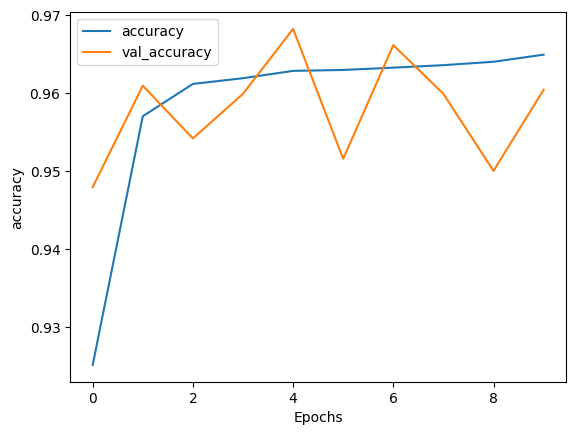

In [36]:
plot_graphs(historyLSTM, "accuracy")


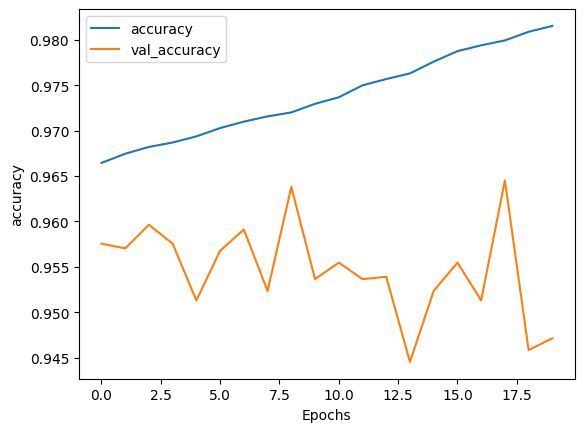

In [37]:
plot_graphs(historyLSTM128_20, "accuracy")